In [39]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras_tqdm import TQDMNotebookCallback
import keras.callbacks

import pandas as pd
import numpy as np
import seaborn as sns
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
FILE_NEXT_TO_GO = 'next_to_go.pkl'
with open(FILE_NEXT_TO_GO, 'rb') as f:
    meeting = pickle.load(f)
print(meeting.keys())
horses = meeting['runners']

dict_keys(['raceNumber', 'raceName', 'raceDistance', 'trackDirection', 'meeting', 'skyRacing', 'hasParimutuel', 'hasFixedOdds', 'broadcastChannel', 'broadcastChannels', 'hasForm', 'hasEarlySpeedRatings', 'allIn', 'cashOutEligibility', 'allowBundle', 'willHaveFixedOdds', 'fixedOddsOnlineBetting', 'raceStartTime', 'raceClassConditions', 'apprenticesCanClaim', 'prizeMoney', 'raceStatus', 'substitute', 'results', 'pools', 'allowMulti', 'allowParimutuelPlace', 'parimutuelPlaceStatus', 'allowFixedOddsPlace', 'numberOfPlaces', 'numberOfFixedOddsPlaces', 'runners', 'oddsUpdateTime', 'fixedOddsUpdateTime', 'tips', 'ratings', 'multiLegApproximates', 'betTypes'])


In [3]:
engine = create_engine('sqlite:///tab.db')
conn = engine.connect()
conn
dfo = pd.read_sql_table('race', conn)
print(dfo.columns)

Index(['id', 'runner_name', 'sire', 'dam', 'age', 'sex', 'colour', 'trainer',
       'trainer_location', 'start_type', 'raced_at', 'race_number',
       'finishing_position', 'number_of_starters', 'draw', 'margin', 'venue',
       'audio', 'video', 'distance', 'class_', 'handicap', 'rider',
       'starting_position', 'odds', 'winner_or_second', 'position_in_run',
       'track_condition', 'time'],
      dtype='object')


In [4]:
df = dfo[['odds', 'finishing_position', 'number_of_starters']]
# print(df.odds.head())
# print(df.finishing_position.head())
print(len(df))
df = df[(df.odds > 0)]
df['finishing_position'] = df.finishing_position.astype(int)
df = df[(df.finishing_position > 0)]
df = df[(df.number_of_starters > 0)]
# print(df.finishing_position.head())
print(len(df))

2735
2613


count    2613.000000
mean       22.174474
std        26.420664
min         1.400000
25%         6.000000
50%        12.000000
75%        26.000000
max       201.000000
Name: odds, dtype: float64

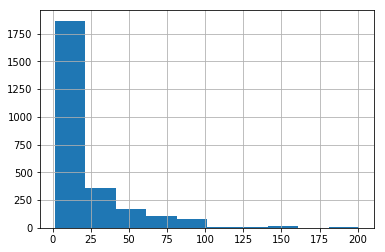

In [44]:
x0 = df['odds']
x0.hist()
x0.describe()

count    2613.000000
mean       11.167623
std         2.517518
min         3.000000
25%         9.000000
50%        11.000000
75%        13.000000
max        21.000000
Name: number_of_starters, dtype: float64

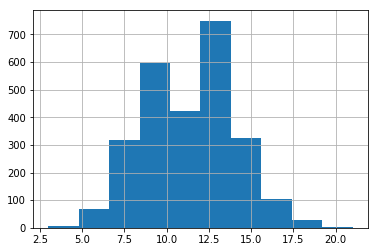

In [45]:
x1 = df['number_of_starters']
x1.hist()
x1.describe()

/Users/jaco/.pyenv/versions/3.6.1/envs/tabby/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


count    2613.000000
mean        0.141217
std         0.348312
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: finishing_position, dtype: float64

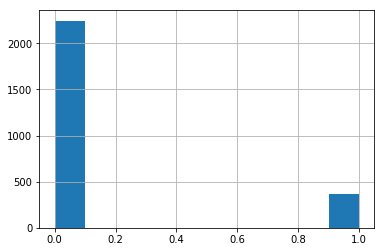

In [46]:
y = df['finishing_position']
y[y > 1] = 0
y.hist()
y.describe()

count    2613.000000
mean        0.141217
std         0.348312
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: finishing_position, dtype: float64

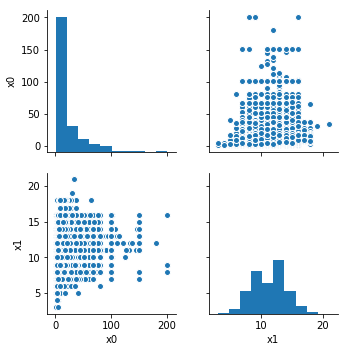

In [47]:
data = pd.DataFrame()
data['x0'] = x0
data['x1'] = x1
sns.pairplot(data)

labels = pd.Series(y)
labels.describe()

In [65]:
# For a single-input model with 2 classes (binary classification):

model = Sequential()
model.add(Dense(20, activation='relu', input_dim=2))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model, iterating on the data in batches of 32 samples

tqdm = TQDMNotebookCallback()

tbCallBack = keras.callbacks.TensorBoard(
    log_dir='/Users/jaco/code/tabby/summary', 
    histogram_freq=0,
    write_graph=True,
    write_images=True)

model.fit(
    data.as_matrix(), 
    labels.as_matrix(), 
    epochs=10000,
    batch_size=128,
    verbose=0,
    callbacks=[tqdm, tbCallBack])

# creates a HDF5 file 'my_model.h5'
model.save('/Users/jaco/code/tabby/my_model.h5')

In [38]:
n = len(horses)
data = [(h['fixedOdds']['returnWin'], n) for h in horses]
preds = model.predict(np.array(data))
# print(preds)

preds_sum = sum(preds)
# print('sum = {}'.format(preds_sum))

preds_p = preds / preds_sum
# print(preds_p)
# print(sum(preds_p))

for horse, p in zip(horses, preds_p):
    name = horse['runnerName']
    odds = horse['fixedOdds']['returnWin']
    print('{} with odds {} has {:.2f}'.format(name, odds, p[0]))

GHARRY WALLAH with odds 34 has 0.02
TOW ROPE with odds 2.15 has 0.29
DIAMONDS FOR ALL with odds 13 has 0.08
MAGICAL STONES with odds 13 has 0.08
YUKON GOLD with odds 13 has 0.08
PUSKAS with odds 19 has 0.05
OAKHURST REBEL with odds 13 has 0.08
NUN TOO SAVVY with odds 10 has 0.09
BEVANDA with odds 34 has 0.02
FAIR FOOT with odds 7.5 has 0.11
COUNTRY FOX with odds 71 has 0.00
DANISH GEM with odds 81 has 0.00
INDEYKA with odds 101 has 0.00
EVIE ON MY MIND with odds 8 has 0.11
